In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import pickle
import os
import time
import datetime
from matplotlib import patches
import multi_tracker_analysis as mta
import scipy.stats
import figurefirst as fifi
import pandas
import copy
import flystat
import fly_plot_lib.plot as fpl
import matplotlib.patches as mpatches

/home/caveman/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


1.5.1
recommended version: 1.1.1 or greater


In [2]:
from numpy import random, histogram2d, diff
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/caveman/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
fififig = 'figures/foraging_fig_3_revision.svg'

In [5]:
def load_data():
    df = pandas.read_hdf('data/flydata_20210428_3cam.hdf', 'flydata_20210428_3cam')


    minimum_req_visits = 3
    flids_okay = []
    for flid in df.flid.unique():
        dfq = df[df.flid==flid]
        if len(dfq) >= minimum_req_visits:
            flids_okay.append(flid)
    df = df[df.flid.isin(flids_okay)]

    df.fraction_of_time_near_odor += 1e-4 # to help with logs

    # spatial novelty
    new_camera = []
    for ix in range(len(df)):
        nc = 1
        try:
            if df.iloc[ix].flid == df.iloc[ix-1].flid:
                if df.iloc[ix].camera != df.iloc[ix-1].camera:
                    nc = 2
            else:
                nc = 2
        except:
            nc = 2 # first one
        new_camera.append(nc)
    df['new_camera'] = new_camera

    # nth visit
    nth_visit = [1]
    for ix in range(1, len(df)):
        if df.iloc[ix].flid == df.iloc[ix-1].flid:
            nth_visit.append(nth_visit[-1]+1)
        else:
            nth_visit.append(1)
    df['nth_visit'] = nth_visit
    df['log_nth_visit'] = np.log(nth_visit)

    df['mean_interval'] = np.nanmean([df['interval'].values, df['interval2'].values], axis=0)
    df['approached_odor'] = np.sign(df['fraction_of_time_near_odor']-0.01)

    df['camera_num'] = (df['camera'] == 'center_camera')
    df['camera_num'] = (df['camera_num'] -1) /2

    return df

In [6]:
df = load_data()
df = df[ ~ (df.nth_visit==1) ] # drop the first visits for this analysis
df = df[df.interval > 0] # there is one encoutner with a negative interval
#df.fraction_of_time_near_odor += 1e-4 # to help with logs

# Distance travelled

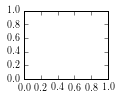

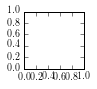

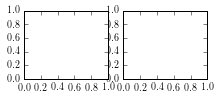

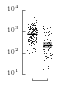

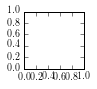

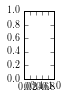

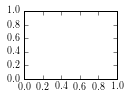

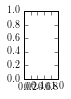

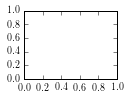

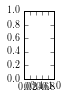

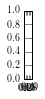

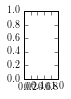

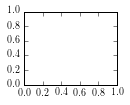

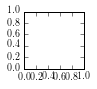

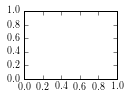

In [7]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('distance_v_approaches', 'distance_v_approaches')]

fpl.scatter_box(ax, 1, np.log(df.query('approached_odor==1').distance_travelled).dropna().values, 
                color='black', markersize=1, use='mean')

fpl.scatter_box(ax, 2, np.log(df.query('approached_odor==-1').distance_travelled).dropna().values, 
                color='black', markersize=1, use='mean')

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)
ax.set_xlim(0.5, 2.5)
#ax.set_ylim(10**1, 10**4)
yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [1, 2]
xticklabels = ['', '']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['distance_v_approaches'], 'distance_v_approaches', cleartarget=True)
layout.write_svg(fififig)

In [8]:
flystat.resampling.calc_statistical_significance_through_resampling(np.log(df.query('approached_odor==1').distance_travelled).values,
                     np.log(df.query('approached_odor==-1').distance_travelled).values, analysis='mean')

(0.0020000000000000018, 0.607, 0.986)

# First approaches

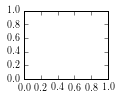

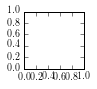

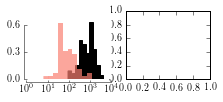

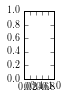

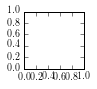

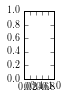

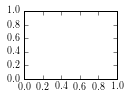

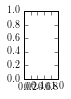

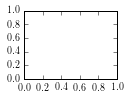

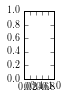

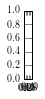

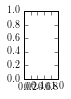

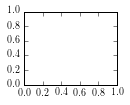

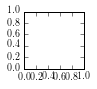

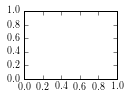

In [9]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('first_approach', 'approached')]



d = df[df.distance_travelled_before_first_approach>0].distance_travelled.values
logd = np.log(d)
ax.hist(logd, color='black', normed=True)


d = df[df.distance_travelled_before_first_approach>0].distance_travelled_before_first_approach.values
logd = np.log(d)
ax.hist(logd, edgecolor='none', facecolor='salmon', alpha=0.7, normed=True)

xticks = [1, 10**1, 10**2, 10**3, 10**4]
xticklabels = ['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$']

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=[0, 0.3, 0.6], 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_ylim(0, 0.75)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

#fifi.mpl_functions.set_fontsize(ax.figure, 8)
#layout.append_figure_to_layer(layout.figures['distance_v_time'], 'distance_v_time', cleartarget=True)
#layout.write_svg(fififig)

In [10]:
ax = layout.axes[('first_approach', 'no_approach')]

d = df[df.distance_travelled_before_first_approach<0].distance_travelled.values
logd = np.log(d)
ax.hist(logd, edgecolor='none', facecolor='gray', normed=True)


d = df[df.distance_travelled_before_first_approach>0].distance_travelled_before_first_approach.values
logd = np.log(d)
ax.hist(logd, edgecolor='none', facecolor='salmon', alpha=0.7, normed=True)

xticks = [1, 10**1, 10**2, 10**3, 10**4]
xticklabels = ['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$']

fifi.mpl_functions.adjust_spines(ax, ['bottom'], 
                                 yticks=[0, 0.3, 0.6], 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_ylim(0, 0.75)

ax.set_xticklabels(xticklabels)
ax.minorticks_off()


fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['first_approach'], 'first_approach', cleartarget=True)
layout.write_svg(fififig)

# Speed for trajecs that approached and those that did not.

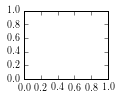

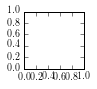

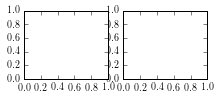

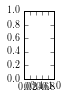

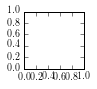

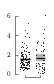

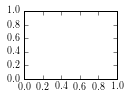

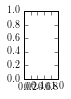

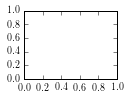

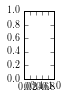

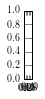

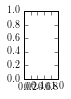

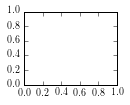

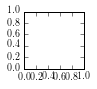

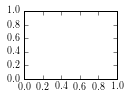

In [11]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('speed_v_approaches', 'speed_v_approaches')]

fpl.scatter_box(ax, 1, (df.query('approached_odor==1').speed).dropna().values, 
                color='black', markersize=1, use='mean')

fpl.scatter_box(ax, 2, (df.query('approached_odor==-1').speed).dropna().values, 
                color='black', markersize=1, use='mean')

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)
ax.set_xlim(0.5, 2.5)
#ax.set_ylim(10**1, 10**4)
yticks = [0, 2, 4, 6]

xticks = [1, 2]
xticklabels = ['', '']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=yticks, 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['speed_v_approaches'], 'speed_v_approaches', cleartarget=True)
layout.write_svg(fififig)

In [12]:
flystat.resampling.calc_statistical_significance_through_resampling((df.query('approached_odor==1').speed).dropna().values,
                     (df.query('approached_odor==-1').speed).dropna().values, analysis='mean')

(0.28600000000000003, 0.009, 0.145)

### Direction of the correlation

One potential explanation is that flies are more likely to approach the odor if they travel farther.
There is, however, a negative correlation between the time when the odors first approached the odor, and how long they travel for. 
In other words, flies walk farther in search of food, the sooner they interact with the odor.
Surprisingly, the flies with an average walking speed that is higher, approach the odor later in their search.
Why might flies be more likely to approach the odor?

Answer might be: how they actually got to the platform in the first place.

#### There is no correlation between how long it takes the fly to approach the odor, and the distance they travel

Results are consistent with the idea that when the flies land, their prior experience with the odor, or their visual experience, are influencing how quickly they approach the odor, even though the all appear to land on similar parts of the platform. 

Flow over the objects is different. 

In [13]:
log_df = pandas.DataFrame()
log_df['approached_odor'] = df.approached_odor.values
log_df['distance_travelled'] = np.log(df.distance_travelled)
log_df['time_of_first_approach'] = np.log(df.time_of_first_approach)

log_df = log_df.query('approached_odor == 1')
log_df.dropna(inplace=True)

ax.scatter(log_df.time_of_first_approach.values, log_df.distance_travelled.values, c='black', s=3, linewidth=0.25,rasterized=True)


# Rerun and OLS on just this input
md = smf.ols('distance_travelled ~ time_of_first_approach', log_df)
mdf2 = md.fit()
print(mdf2.summary())

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:     distance_travelled   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.156
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0799
Time:                        16:00:50   Log-Likelihood:                -84.909
No. Observations:                  73   AIC:                             173.8
Df Residuals:                      71   BIC:                             178.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

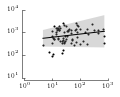

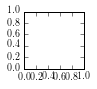

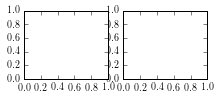

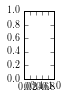

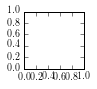

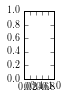

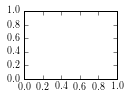

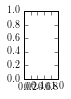

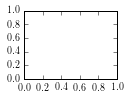

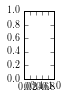

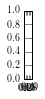

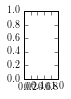

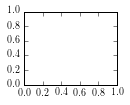

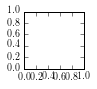

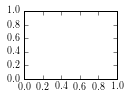

In [14]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('distance_v_time', 'distance_v_time')]



ax.scatter(log_df.time_of_first_approach, #/log_df_approached.search_time, 
         log_df.distance_travelled, c='black', s=3, linewidth=0.25,rasterized=True)

x = np.linspace(np.min(log_df.time_of_first_approach.values), np.max(log_df.time_of_first_approach.values), 100)
y = mdf2.params['time_of_first_approach']*x + mdf2.params['Intercept']
ax.plot(x, y, color='black')


if 1:
    # show the confidence interval around the slope and mean
    conf95 = mdf2.conf_int(alpha=0.05, cols=None)
    input_coeff_conf_lo = conf95[0]['time_of_first_approach']
    input_coeff_conf_hi = conf95[1]['time_of_first_approach']
    
    intercept_conf_lo = conf95[0]['Intercept']
    intercept_conf_hi = conf95[1]['Intercept']
    
    y_hi_hi = input_coeff_conf_hi*x + intercept_conf_hi
    y_hi_lo = input_coeff_conf_hi*x + intercept_conf_lo
    y_lo_hi = input_coeff_conf_lo*x + intercept_conf_hi
    y_lo_lo = input_coeff_conf_lo*x + intercept_conf_lo
    
    y = np.vstack([y_hi_hi, y_hi_lo, y_lo_hi, y_lo_lo])
    y = np.sort(y, axis=0)
    
    ax.fill_between(x, y[0,:], y[-1,:], facecolor='gray', edgecolor='none', alpha=0.3)
    
    
    
yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [10**0, 10**1, 10**2, 10**3]
xticklabels = ['$10^0$', '$10^1$', '$10^2$', '$10^3$']

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=np.log(xticks),
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['distance_v_time'], 'distance_v_time', cleartarget=True)
layout.write_svg(fififig)

### Much more likely to approach if landing on the center platform!

Perhaps because they are likely flying in the plume, and then landing?

In [15]:
log_df = copy.copy(df)
log_df['log_distance_travelled'] = np.log(df.distance_travelled)
log_df['log_interval'] = np.log(df.interval)

In [16]:
log_df['approached_odor_binary'] = (log_df.approached_odor+1)/2.

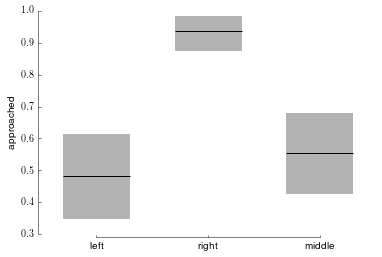

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

fpl.scatter_box(ax, 1, log_df.query("camera=='left_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

fpl.scatter_box(ax, 3, log_df.query("camera=='right_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

fpl.scatter_box(ax, 2, log_df.query("camera=='center_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 xticks=[1, 2, 3],
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})

ax.set_xticklabels(['left', 'right', 'middle'])

ax.set_ylabel('approached')

In [18]:
flystat.resampling.calc_statistical_significance_through_resampling(\
                log_df.query("camera=='left_camera'").approached_odor_binary.dropna().values,
                log_df.query("camera=='center_camera'").approached_odor_binary.dropna().values)

(0.0, 0.663, 0.0)

### FIFI

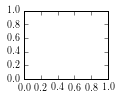

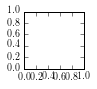

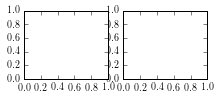

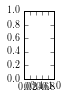

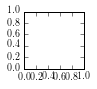

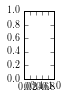

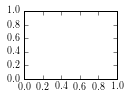

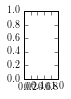

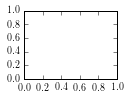

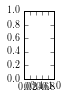

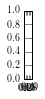

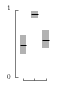

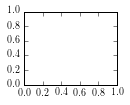

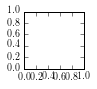

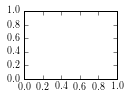

In [19]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('approaches_v_patch', 'approaches_v_patch')]

fpl.scatter_box(ax, 1, log_df.query("camera=='left_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

fpl.scatter_box(ax, 3, log_df.query("camera=='right_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

fpl.scatter_box(ax, 2, log_df.query("camera=='center_camera'").approached_odor_binary.dropna().values, 
                color='black', markersize=5, use='mean', hide_markers=True)

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)
ax.set_xlim(0.5, 3.5)
ax.set_ylim(0, 1)
yticks = [0, 1]
yticklabels = ['$0$', '$1$']

xticks = [1, 2, 3]
xticklabels = ['', '', '']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=yticks, 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['approaches_v_patch'], 'approaches_v_patch', cleartarget=True)
layout.write_svg(fififig)

### Interval for each platform

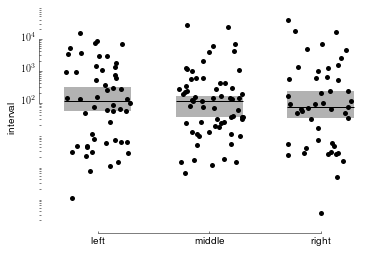

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

fpl.scatter_box(ax, 1, log_df.query("camera=='left_camera'").interval.dropna().values, 
                color='black', markersize=5, use='median', hide_markers=False)

fpl.scatter_box(ax, 3, log_df.query("camera=='right_camera'").interval.dropna().values, 
                color='black', markersize=5, use='median', hide_markers=False)

fpl.scatter_box(ax, 2, log_df.query("camera=='center_camera'").interval.dropna().values, 
                color='black', markersize=5, use='median', hide_markers=False)



ax.set_xticklabels(['left', 'middle', 'right'])

ax.set_ylabel('interval')

ax.set_yscale('log')

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 xticks=[1, 2, 3],
                                 yticks=[10**2, 10**3, 10**4],
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})

In [21]:
flystat.resampling.calc_statistical_significance_through_resampling(\
                log_df.query("camera=='right_camera'").log_interval.dropna().values,
                log_df.query("camera=='center_camera'").log_interval.dropna().values)

(0.46799999999999997, 0.022, 0.03)

In [22]:
flystat.resampling.calc_statistical_significance_through_resampling(\
                log_df.query("camera=='right_camera'").interval.dropna().values,
                log_df.query("camera=='center_camera'").interval.dropna().values)

(0.382, 0.058, 0.025)

#### Interval is no different. This is just another way of seeing that the interval and approaches are in fact independent

This suggests that the explanation is not that flies land on the downwind platform. 

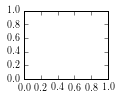

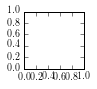

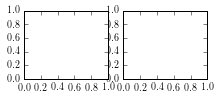

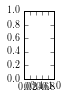

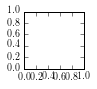

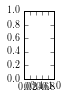

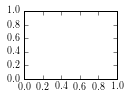

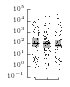

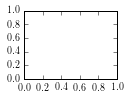

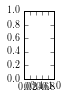

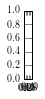

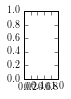

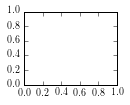

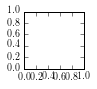

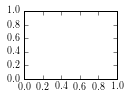

In [23]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('interval_v_patch', 'interval_v_patch')]

fpl.scatter_box(ax, 1, log_df.query("camera=='left_camera'").interval.dropna().values, 
                color='black', markersize=1, use='median', hide_markers=False)

fpl.scatter_box(ax, 3, log_df.query("camera=='right_camera'").interval.dropna().values, 
                color='black', markersize=1, use='median', hide_markers=False)

fpl.scatter_box(ax, 2, log_df.query("camera=='center_camera'").interval.dropna().values, 
                color='black', markersize=1, use='median', hide_markers=False)

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)
ax.set_xlim(0.5, 3.5)
ax.set_ylim(10**-1, 10**5)

xticks = [1, 2, 3]
xticklabels = ['', '', '']


ax.set_yscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)

yticks = [10**-1, 1, 10**1, 10**2, 10**3, 10**4, 10**5]
yticklabels = ['$10^{-1}$', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=yticks, 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['interval_v_patch'], 'interval_v_patch', cleartarget=True)
layout.write_svg(fififig)


## Digging into the approach vs no approach more

Why are flies that land on center platform more likely to approach? 

Perhaps it has to do with where on the platform they land. 

All the flies land on downwind end. 

In [24]:
left_camera = {'x': 335, 'y': 263, 'r': 229}
right_camera = {'x':385, 'y':248, 'r': 232}
center_camera = {'x': 356, 'y':259, 'r':191}

In [25]:
angles_of_landing = []
approach_stats = []
distances_travelled = []
speeds = []

In [26]:
log_df['angle_of_landing'] = 0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.472222222222


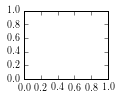

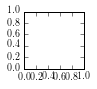

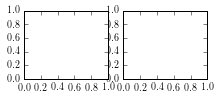

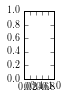

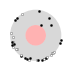

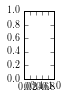

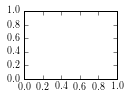

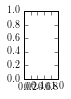

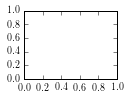

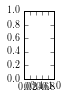

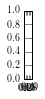

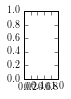

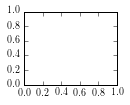

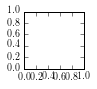

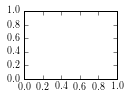

In [27]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('landings_right', 'landings_right')]

upwind = 0
downwind = 0
for i in range(len(df)):
    try:
        if df['camera'][i] == 'right_camera':
            data = pandas.read_hdf('data/' + df['all_trajec_ids'][i])
            ax.scatter(data.pos_x_mm[0], -1*data.pos_y_mm[0], c=df['approached_odor'][i], 
                       cmap='bone_r', vmin=-1, vmax=1, s=5, linewidth=0.25)
            
            
            angle_from_downwind = np.abs( np.arctan2(data.pos_y_mm[0], np.abs(data.pos_x_mm[0]) )*180/np.pi - 90 )
            angles_of_landing.append(angle_from_downwind)
            approach_stats.append(df['approached_odor'][i])
            distances_travelled.append(df['distance_travelled'][i])
            speeds.append(df['speed'][i])
            log_df.angle_of_landing[i] = angle_from_downwind
            if angle_from_downwind > 45:
                upwind += 1
            else:
                downwind += 1
                
    except:
        pass
    
print( (downwind)/float(downwind+upwind) )

ax.set_aspect('equal')
ax.set_xlim(-60, 60)
ax.set_ylim(-60,60)
fifi.mpl_functions.adjust_spines(ax, [])


circle = patches.Circle([0, 0], radius=108/2.,
                       facecolor='gray', edgecolor='none', alpha=0.3, zorder=-10)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='white', edgecolor='none', alpha=1, zorder=-9)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='red', edgecolor='none', alpha=0.3, zorder=-8)
ax.add_artist(circle)



layout.append_figure_to_layer(layout.figures['landings_right'], 'landings_right', cleartarget=True)
layout.write_svg(fififig)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.530612244898


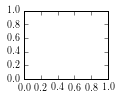

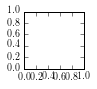

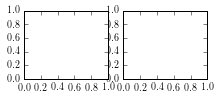

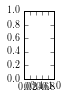

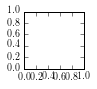

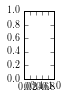

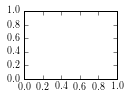

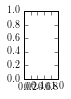

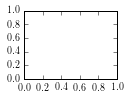

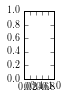

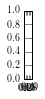

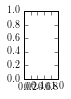

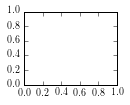

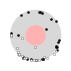

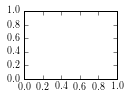

In [28]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('landings_left', 'landings_left')]


upwind = 0
downwind = 0
for i in range(len(df)):
    try:
        if df['camera'][i] == 'left_camera':
            data = pandas.read_hdf('data/' + df['all_trajec_ids'][i])
            ax.scatter(data.pos_x_mm[0], -1*data.pos_y_mm[0], c=df['approached_odor'][i], 
                       cmap='bone_r', vmin=-1, vmax=1, s=5, linewidth=0.25)
            
            
            angle_from_downwind = np.abs( np.arctan2(data.pos_y_mm[0], np.abs(data.pos_x_mm[0]) )*180/np.pi - 90 )
            angles_of_landing.append(angle_from_downwind)
            approach_stats.append(df['approached_odor'][i])
            distances_travelled.append(df['distance_travelled'][i])
            speeds.append(df['speed'][i])
            log_df.angle_of_landing[i] = angle_from_downwind
            if angle_from_downwind > 45:
                upwind += 1
            else:
                downwind += 1
                
    except:
        pass
    
print( (downwind)/float(downwind+upwind) )

ax.set_aspect('equal')
ax.set_xlim(-60, 60)
ax.set_ylim(-60,60)
fifi.mpl_functions.adjust_spines(ax, [])

circle = patches.Circle([0, 0], radius=108/2.,
                       facecolor='gray', edgecolor='none', alpha=0.3, zorder=-10)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='white', edgecolor='none', alpha=1, zorder=-9)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='red', edgecolor='none', alpha=0.3, zorder=-8)
ax.add_artist(circle)

layout.append_figure_to_layer(layout.figures['landings_left'], 'landings_left', cleartarget=True)
layout.write_svg(fififig)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.732142857143


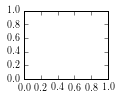

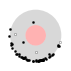

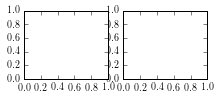

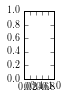

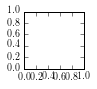

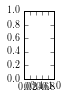

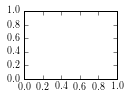

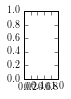

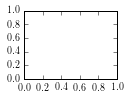

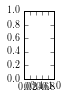

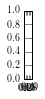

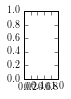

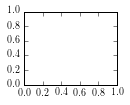

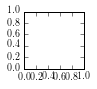

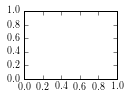

In [29]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('landings_center', 'landings_center')]

upwind = 0
downwind = 0
for i in range(len(df)):
    try:
        if df['camera'][i] == 'center_camera':
            data = pandas.read_hdf('data/' + df['all_trajec_ids'][i])
            ax.scatter(data.pos_x_mm[0], -1*data.pos_y_mm[0], c=df['approached_odor'][i], 
                       cmap='bone_r', vmin=-1, vmax=1, s=5, linewidth=0.25)
            
            
            
            angle_from_downwind = np.abs( np.arctan2(data.pos_y_mm[0], np.abs(data.pos_x_mm[0]) )*180/np.pi - 90 )
            angles_of_landing.append(angle_from_downwind)
            approach_stats.append(df['approached_odor'][i])
            distances_travelled.append(df['distance_travelled'][i])
            speeds.append(df['speed'][i])
            log_df.angle_of_landing[i] = angle_from_downwind
            if angle_from_downwind > 45:
                upwind += 1
            else:
                downwind += 1
                
    except:
        pass
    
print( (downwind)/float(downwind+upwind) )

ax.set_aspect('equal')
ax.set_xlim(-60, 60)
ax.set_ylim(-60,60)
fifi.mpl_functions.adjust_spines(ax, [])


circle = patches.Circle([0, 0], radius=108/2.,
                       facecolor='gray', edgecolor='none', alpha=0.3, zorder=-10)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='white', edgecolor='none', alpha=1, zorder=-9)
ax.add_artist(circle)
circle = patches.Circle([0, 0], radius=0.4*108/2.,
                       facecolor='red', edgecolor='none', alpha=0.3, zorder=-8)
ax.add_artist(circle)

# did not approach = white

layout.append_figure_to_layer(layout.figures['landings_center'], 'landings_center', cleartarget=True)
layout.write_svg(fififig)

In [30]:
approach_stats = np.array(approach_stats)
angles_of_landing = np.array(angles_of_landing)
distances_travelled = np.array(distances_travelled)
speeds = np.array(speeds)

In [31]:
idx_appr = np.where(approach_stats==1)
idx_noappr = np.where(approach_stats==-1)

In [32]:
import fly_plot_lib.plot as fpl

### No correlation between the angle at which flies land and whether they approach or not

Not really surprising - should not be hard to find the odor on these patches.

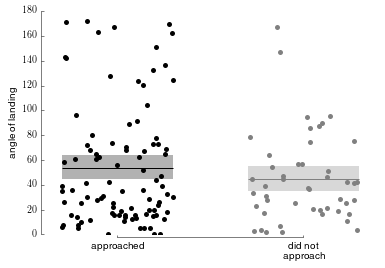

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

fpl.scatter_box(ax, 1, angles_of_landing[idx_appr], 
                color='black', markersize=5, use='mean')

fpl.scatter_box(ax, 2, angles_of_landing[idx_noappr], 
                color='gray', markersize=5, use='mean')

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 xticks=[1, 2],
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_xticklabels(['approached', 'did not\napproach'])

ax.set_ylabel('angle of landing')

In [34]:
flystat.resampling.calc_statistical_significance_through_resampling(angles_of_landing[idx_appr],
                                                                    angles_of_landing[idx_noappr])

(0.808, 0.03, 0.009)

In [35]:
scipy.stats.ks_2samp(angles_of_landing[idx_appr], angles_of_landing[idx_noappr])

Ks_2sampResult(statistic=0.15957446808510634, pvalue=0.3716592394396068)

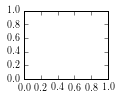

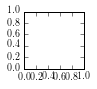

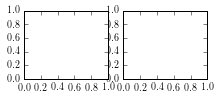

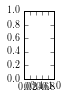

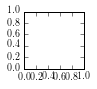

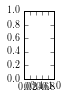

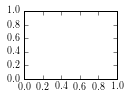

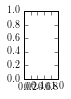

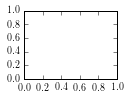

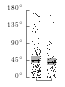

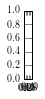

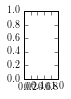

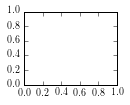

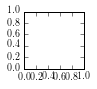

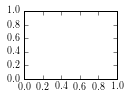

In [36]:
layout = fifi.svg_to_axes.FigureLayout(fififig, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])
ax = layout.axes[('angle_v_approaches', 'angle_v_approaches')]

fpl.scatter_box(ax, 1, log_df.query('approached_odor==1').angle_of_landing.dropna().values, 
                color='black', markersize=1, use='mean')

fpl.scatter_box(ax, 2, log_df.query('approached_odor==-1').angle_of_landing.dropna().values, 
                color='black', markersize=1, use='mean')

#ax.set_xscale('log')

#ax.set_ylim(2.2,9.22)
#ax.set_xlim(0, 7)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-2, 180)
yticks = [0, 45, 90, 135, 180]
yticklabels = ['$0^{\circ}$', '$45^{\circ}$', '$90^{\circ}$', '$135^{\circ}$', '$180^{\circ}$']

xticks = [1, 2]
xticklabels = ['', '']


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=yticks, 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

fifi.mpl_functions.set_fontsize(ax.figure, 6)
layout.append_figure_to_layer(layout.figures['angle_v_approaches'], 'angle_v_approaches', cleartarget=True)
layout.write_svg(fififig)

### Angle of landing is not correlated with distance travelled

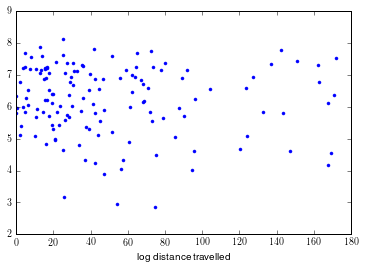

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(angles_of_landing, np.log(distances_travelled), '.' )

ax.set_xlabel('angle of landing')
ax.set_xlabel('log distance travelled')

In [38]:
scipy.stats.linregress(angles_of_landing, np.log(distances_travelled))

LinregressResult(slope=-0.0020795572135343977, intercept=6.3127638573564715, rvalue=-0.08441991258329676, pvalue=0.3195973482611121, stderr=0.0020819269466039836)

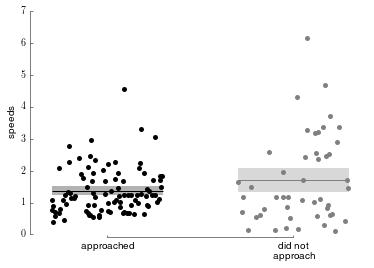

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

fpl.scatter_box(ax, 1, speeds[idx_appr], 
                color='black', markersize=5, use='mean')

fpl.scatter_box(ax, 2, speeds[idx_noappr], 
                color='gray', markersize=5, use='mean')

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 xticks=[1, 2],
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_xticklabels(['approached', 'did not\napproach'])

ax.set_ylabel('speeds')

In [40]:
flystat.resampling.calc_statistical_significance_through_resampling(speeds[idx_appr],
                                                                    speeds[idx_noappr])

(0.6499999999999999, 0.006, 0.239)

### Some landing stats

In [41]:
df = load_data()

In [42]:
n_center_approached = 0
n_center_noapproach = 0

n_right_approached = 0
n_right_noapproach = 0

n_left_approached = 0
n_left_noapproach = 0

In [43]:
len(df)

179

In [44]:
#df.reset_index(inplace=True)
for i in range(len(df)):
    try:
        if df.iloc[i]['camera'] == 'right_camera':
            if df.iloc[i]['approached_odor'] == 1:
                n_right_approached += 1
            else:
                n_right_noapproach += 1
        if df.iloc[i]['camera'] == 'left_camera':
            if df.iloc[i]['approached_odor'] == 1:
                n_left_approached += 1
            else:
                n_left_noapproach += 1
        if df.iloc[i]['camera'] == 'center_camera':
            if df.iloc[i]['approached_odor'] == 1:
                n_center_approached += 1
            else:
                n_center_noapproach += 1
    except:
        pass

In [45]:
print('Center camera')
print('Total: ', n_center_approached+n_center_noapproach)
print('Fraction approached: ', float(n_center_approached) / float(n_center_approached + n_center_noapproach))

Center camera
('Total: ', 68)
('Fraction approached: ', 0.9264705882352942)


In [46]:
print('Right camera')
print('Total: ', n_right_noapproach+n_right_approached)
print('Fraction approached: ', float(n_right_approached) / float(n_right_approached + n_right_noapproach))

Right camera
('Total: ', 52)
('Fraction approached: ', 0.5192307692307693)


In [47]:
print('Left camera')
print('Total: ', n_left_noapproach+n_left_approached)
print('Fraction approached: ', float(n_left_approached) / float(n_left_approached + n_left_noapproach))

Left camera
('Total: ', 59)
('Fraction approached: ', 0.4915254237288136)
